# Projet 09 - Prédire la demande en électricité

---

## <font color=blue>Sommaire</font>

[0. Préparation des données](#0_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[0.1. Données dju sur les températures](#0_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[0.2. Données sur la consommation électrique](#0_2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[0.3. Création d'un dataframe avec les deux séries de valeurs](#0_3)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[0.4. Date de fin des données](#0_4)  
  
[1. Corriger les données de consommation mensuelles de l'effet température](data_analyst_projet09_M1M2M3_analyse_donnees.ipynb)  
  
[2. Désaisonnaliser la consommation corrigée](data_analyst_projet09_M1M2M3_analyse_donnees.ipynb)  
  
[3. Prévoir la consommation sur un an](data_analyst_projet09_M1M2M3_analyse_donnees.ipynb)

---
**Importation des librairies**

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import scipy.stats as st

import modules_perso.sf_times_series as sft
import modules_perso.sf_graphiques as sfg

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
#import warnings
#warnings.filterwarnings('ignore')

<a id='0_0'></a>

---
## <font color=blue>Mission 0 : Préparation des données</font>

### 0.1. Données dju sur les températures

**Données dju pour Paris**

Je choisis les données pour Paris, qui est la plus grande ville de France. Paris est assez central géographiquement, quoique un peu au Nord, mais surtout avec un climat assez moyen par rapport à ce que l'on peut trouver en France.

In [3]:
dju = pd.read_excel("GRDF_donnees_dju.xlsx", sheet_name='Donnees chauffage')
dju.head()

,date,dju,ville,type_dju
0,2009-01-31,487,Paris,chauffage meteo
1,2009-02-28,366,Paris,chauffage meteo
2,2009-03-31,293,Paris,chauffage meteo
3,2009-04-30,135,Paris,chauffage meteo
4,2009-05-31,82,Paris,chauffage meteo


In [4]:
dju.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3024 entries, 0 to 3023
Data columns (total 4 columns):
date        3024 non-null datetime64[ns]
dju         3024 non-null int64
ville       3024 non-null object
type_dju    3024 non-null object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 94.6+ KB


In [5]:
dju_meteo_paris = dju[(dju.ville=="Paris")&(dju.type_dju=="chauffage meteo")][["date","dju"]]
dju_pro_paris = dju[(dju.ville=="Paris")&(dju.type_dju=="chauffage pro")][["date","dju"]]

**Données moyennes pour la France**

Une autre possibilité un peu plus complexe est de chercher à calculer une sorte de moyenne nationale. Plusieurs approches sont possibles.  
J'ai effectué ce calcul pour avoir des données en réserve et aller plus loin. J'utiliserai toutefois les données de Paris dans la suite de mon projet.  
Pour calculer des données moyennes, j'ai choisi de prendre les données des villes les plus grandes, en récupérant les informations dju pour les 11 villes de plus de 200 000 habitants (selon le recensement de 2015), puis de faire leur moyenne en les pondérant par la population de chaque ville. Cette approche permet de prendre en compte différents climats, en les pondérant en fonction de la population concernée.

Remarque : il y a beaucoup de données manquantes pour Marseille au début de la série historique (les données commencent fin 2014). De ce fait, je supprime les données pour Marseille et je les remplace par les données d'Aix en Provence, commune voisine, dont j'ai importé les données dans ce but.

In [6]:
dju = dju[dju.ville != "Marseille"]
dju["ville"] = dju.ville.str.replace("Aix en Provence","Marseille")
dju.ville.unique()

array(['Paris', 'Marseille', 'Lyon', 'Toulouse', 'Nice', 'Nantes',
       'Montpellier', 'Strasbourg', 'Bordeaux', 'Lille', 'Rennes'],
      dtype=object)

In [7]:
pop = pd.read_excel("GRDF_donnees_dju.xlsx", sheet_name='Donnees population')
pop.head()

,ville,population,poids
0,Paris,2206488,0.370716
1,Marseille,861635,0.144765
2,Lyon,513275,0.086236
3,Toulouse,471941,0.079292
4,Nice,342522,0.057548


In [8]:
dju = dju.merge(pop[["ville","poids"]], how='left', on='ville')
dju["chauffage"] = dju.dju * dju.poids
dju.head()

,date,dju,ville,type_dju,poids,chauffage
0,2009-01-31,487,Paris,chauffage meteo,0.370716,180.538456
1,2009-02-28,366,Paris,chauffage meteo,0.370716,135.681879
2,2009-03-31,293,Paris,chauffage meteo,0.370716,108.619646
3,2009-04-30,135,Paris,chauffage meteo,0.370716,50.046595
4,2009-05-31,82,Paris,chauffage meteo,0.370716,30.398672


In [9]:
chauffage = dju.groupby(["type_dju","date"]).chauffage.sum().reset_index()
chauffage.head()

,type_dju,date,chauffage
0,chauffage meteo,2009-01-31,407.119385
1,chauffage meteo,2009-02-28,312.854858
2,chauffage meteo,2009-03-31,253.764900
3,chauffage meteo,2009-04-30,131.572008
4,chauffage meteo,2009-05-31,55.413545


In [10]:
dju_meteo_france = chauffage[(chauffage.type_dju=="chauffage meteo")][["date","chauffage"]]
dju_pro_france = chauffage[(chauffage.type_dju=="chauffage pro")][["date","chauffage"]]
dju_meteo_france.columns = ["date","dju"]
dju_pro_france.columns = ["date","dju"]

<a id='0_2'></a>

### 0.2. Données sur la consommation électrique

In [11]:
data_consommation = pd.read_excel("RTE_donnees_energie.xlsx")
data_consommation.head()

,Mois,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,...,Production bio-énergies,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges aves la Suisse,Echanges avec l'Allemagne et la Belgique
0,0000-00,Données consolidées,Grand-Est,7296,5505.0,864,153.0,8,701,537,...,70,3364,3876.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000-00,Données définitives,Nouvelle-Aquitaine,4523,3740.0,26,NaN,9,16,162,...,131,3222,1300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000-00,Données définitives,Auvergne-Rhône-Alpes,8890,5946.0,32,4.0,17,10,2632,...,79,5010,3658.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000-00,Données définitives,Bourgogne-Franche-Comté,152,NaN,19,0.0,0,19,19,...,20,1533,-1383.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000-00,Données définitives,Bretagne,197,NaN,3,NaN,3,0,46,...,37,1493,-1300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
consommation = data_consommation[data_consommation.Territoire == "France"][["Mois","Qualité","Consommation totale"]]
consommation.head()

,Mois,Qualité,Consommation totale
6,0000-00,Données définitives,34585
13,2010-01,Données consolidées,56342
14,2010-02,Données consolidées,48698
15,2010-03,Données consolidées,48294
16,2010-04,Données consolidées,38637


In [13]:
consommation.describe(include='all')

,Mois,Qualité,Consommation totale
count,119,119,119.000000
unique,119,2,NaN
top,2015-08,Données définitives,NaN
freq,1,83,NaN
mean,NaN,NaN,40137.092437
std,NaN,NaN,7235.681637
min,NaN,NaN,31004.000000
25%,NaN,NaN,33931.000000
50%,NaN,NaN,37063.000000
75%,NaN,NaN,45838.000000


Le format du mois de la première ligne ne correspond pas aux autres lignes. Je la supprimme. C'est la seule à avoir cette valeur atypique.

In [14]:
consommation = consommation.iloc[1:].reset_index().drop(columns=["index"])
consommation.head()

,Mois,Qualité,Consommation totale
0,2010-01,Données consolidées,56342
1,2010-02,Données consolidées,48698
2,2010-03,Données consolidées,48294
3,2010-04,Données consolidées,38637
4,2010-05,Données consolidées,37284


In [15]:
consommation.Mois.unique()

array(['2010-01', '2010-02', '2010-03', '2010-04', '2010-05', '2010-06',
       '2010-07', '2010-08', '2010-09', '2010-10', '2010-11', '2010-12',
       '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
       '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12',
       '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06',
       '2012-07', '2012-08', '2012-09', '2012-10', '2012-11', '2012-12',
       '2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06',
       '2013-07', '2013-08', '2013-09', '2013-10', '2013-11', '2013-12',
       '2014-01', '2014-02', '2014-03', '2014-04', '2014-05', '2014-06',
       '2014-07', '2014-08', '2014-09', '2014-10', '2014-11', '2014-12',
       '2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06',
       '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12',
       '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06',
       '2016-07', '2016-08', '2016-09', '2016-10', 

In [16]:
consommation["Mois"] = pd.to_datetime(consommation.Mois)
consommation["Mois"] = consommation.Mois + pd.DateOffset(months=1) - pd.DateOffset(days=1)
consommation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
Mois                   118 non-null datetime64[ns]
Qualité                118 non-null object
Consommation totale    118 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ KB


In [17]:
consommation.columns = ["date","xxx","consommation"]
consommation.drop(columns=["xxx"], inplace=True)
consommation.head()

,date,consommation
0,2010-01-31,56342
1,2010-02-28,48698
2,2010-03-31,48294
3,2010-04-30,38637
4,2010-05-31,37284


<a id='0_3'></a>

### 0.3. Création d'un dataframe avec les deux séries de valeurs

**Comparaison des données**

In [18]:
ts_conso = sft.TimeSerie(consommation, time_index='date', serie_values='consommation', model_type='add')
ts_dju_meteo_paris = sft.TimeSerie(dju_meteo_paris, time_index='date', serie_values='dju', model_type='add')
ts_dju_pro_paris = sft.TimeSerie(dju_pro_paris, time_index='date', serie_values='dju', model_type='add')
ts_dju_meteo_france = sft.TimeSerie(dju_meteo_france, time_index='date', serie_values='dju', model_type='add')
ts_dju_pro_france = sft.TimeSerie(dju_pro_france, time_index='date', serie_values='dju', model_type='add')

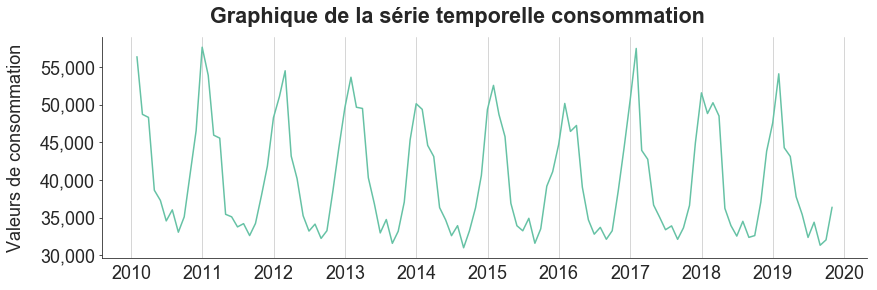

In [33]:
fig, ax = ts_conso.tsplot(figsize=(12,4))
ax[0].yaxis.set_major_formatter(plticker.StrMethodFormatter('{x:,.0f}'))
ax[0].set_xlabel("")
plt.savefig("M0_g1_ts_conso.png")
plt.show()

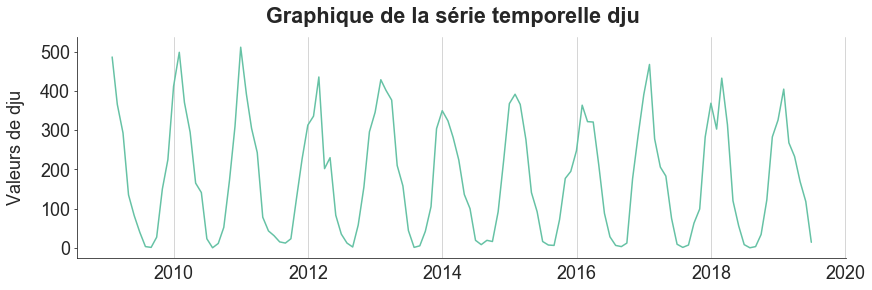

In [35]:
fig, ax = ts_dju_meteo_paris.tsplot(figsize=(12,4))
ax[0].set_xlabel("")
plt.savefig("M0_g2_ts_dju_meteo_paris.png")
plt.show()

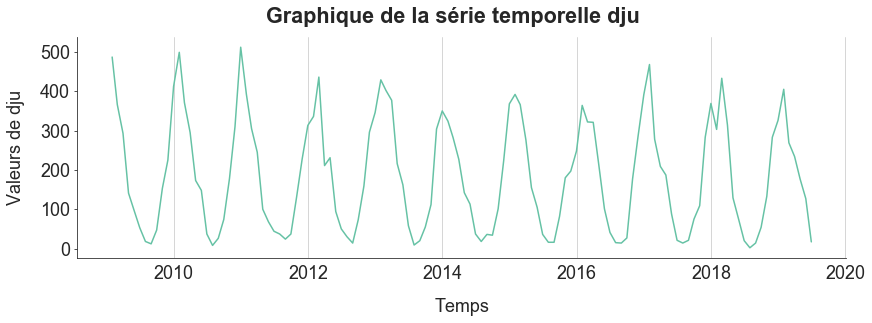

In [21]:
fig, ax = ts_dju_pro_paris.tsplot(figsize=(12,4))
plt.show()

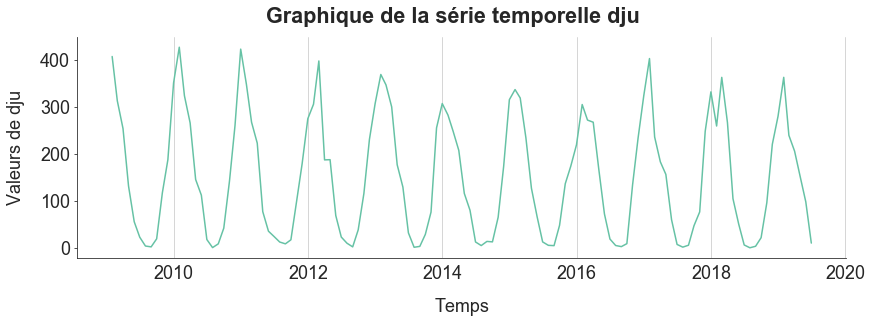

In [22]:
fig, ax = ts_dju_meteo_france.tsplot(figsize=(12,4))
plt.show()

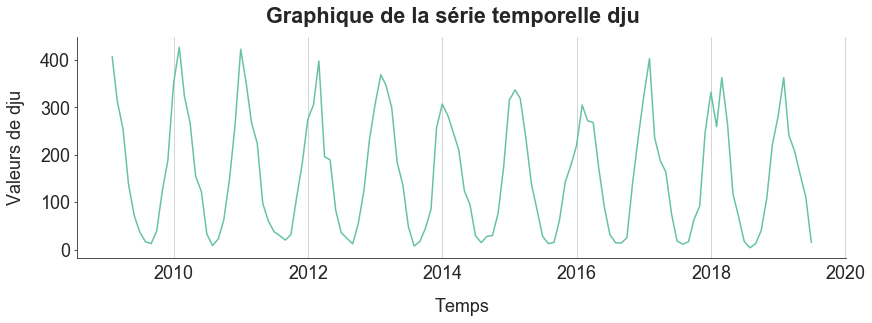

In [23]:
fig, ax = ts_dju_pro_france.tsplot(figsize=(12,4))
plt.show()

Les séries de valeur dju n'ont pas du tout la même échelle de valeur que la série sur la consommation électrique. Les dates de début et de fin sont également différentes.  
  
Dans certains cas, la consommation corrigée du climat (du chauffage) se calcule en multipliant par un dju de référence et en divisant par le dju de la période de consommation considérée. cf http://www.gpso-energie.fr/conseils/analyser-ses-consommations-dju

Dans notre cas, nous cherchons à enlever l'effet température en estimant son effet saisonnier avec une régression linéaire. Pour que les résultats de la régression linéaire soient exploitables, il faut que les séries de dju aient une variance et une moyenne similaires à la série de la consommation.

**Uniformalisation des données**

In [24]:
consommation = consommation.merge(dju_meteo_paris, how='left', on='date')
consommation = consommation.merge(dju_pro_paris, how='left', on='date')
consommation = consommation.merge(dju_meteo_france, how='left', on='date')
consommation = consommation.merge(dju_pro_france, how='left', on='date')
consommation.columns = ["date","consommation","dju_meteo_paris","dju_pro_paris","dju_meteo_france","dju_pro_france"]
consommation.head()

,date,consommation,dju_meteo_paris,dju_pro_paris,dju_meteo_france,dju_pro_france
0,2010-01-31,56342,499.0,499.0,426.879459,426.879459
1,2010-02-28,48698,371.0,371.0,323.624893,323.624893
2,2010-03-31,48294,295.0,295.0,265.790719,266.359671
3,2010-04-30,38637,165.0,173.0,145.377554,154.749327
4,2010-05-31,37284,141.0,148.0,112.039463,122.500893


In [25]:
consommation.describe()

,consommation,dju_meteo_paris,dju_pro_paris,dju_meteo_france,dju_pro_france
count,118.000000,114.000000,114.000000,114.000000,114.000000
mean,40184.144068,177.517544,184.271930,150.390045,157.686638
std,7248.232031,146.062008,140.420499,126.909421,121.376024
min,31004.000000,0.000000,2.000000,0.078206,3.839907
25%,33929.000000,31.750000,45.500000,21.869564,36.225221
50%,37173.500000,161.500000,167.500000,131.510752,139.076680
75%,45887.500000,303.750000,303.750000,259.779275,260.215668
max,57600.000000,512.000000,512.000000,426.879459,426.879459


Les moyennes et écart-types des séries dju sont très différentes de consommation.

In [26]:
consommation["chauffage_meteo_paris"] = (consommation.dju_meteo_paris * consommation.consommation.std() / consommation.dju_meteo_paris.std())
consommation["chauffage_pro_paris"] = (consommation.dju_pro_paris * consommation.consommation.std() / consommation.dju_pro_paris.std())
consommation["chauffage_meteo_paris"] = (consommation.chauffage_meteo_paris + consommation.consommation.mean() - consommation.chauffage_meteo_paris.mean())
consommation["chauffage_pro_paris"] = (consommation.chauffage_pro_paris + consommation.consommation.mean() - consommation.chauffage_pro_paris.mean())

consommation["chauffage_meteo_france"] = (consommation.dju_meteo_france * consommation.consommation.std() / consommation.dju_meteo_france.std())
consommation["chauffage_pro_france"] = (consommation.dju_pro_france * consommation.consommation.std() / consommation.dju_pro_france.std())
consommation["chauffage_meteo_france"] = (consommation.chauffage_meteo_france + consommation.consommation.mean() - consommation.chauffage_meteo_france.mean())
consommation["chauffage_pro_france"] = (consommation.chauffage_pro_france + consommation.consommation.mean() - consommation.chauffage_pro_france.mean())
consommation.describe()

,consommation,dju_meteo_paris,dju_pro_paris,dju_meteo_france,dju_pro_france,chauffage_meteo_paris,chauffage_pro_paris,chauffage_meteo_france,chauffage_pro_france
count,118.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000
mean,40184.144068,177.517544,184.271930,150.390045,157.686638,40184.144068,40184.144068,40184.144068,40184.144068
std,7248.232031,146.062008,140.420499,126.909421,121.376024,7248.232031,7248.232031,7248.232031,7248.232031
min,31004.000000,0.000000,2.000000,0.078206,3.839907,31374.951580,30775.622882,31599.319747,30996.853418
25%,33929.000000,31.750000,45.500000,21.869564,36.225221,32950.524650,33021.007961,32843.898870,32930.812581
50%,37173.500000,161.500000,167.500000,131.510752,139.076680,39389.283887,39318.409792,39105.882910,39072.810105
75%,45887.500000,303.750000,303.750000,259.779275,260.215668,46448.347482,46351.368805,46431.737933,46306.887027
max,57600.000000,512.000000,512.000000,426.879459,426.879459,56782.618088,57100.827259,55975.402224,56259.576167


Je vérifie graphiquement la cohérence des données

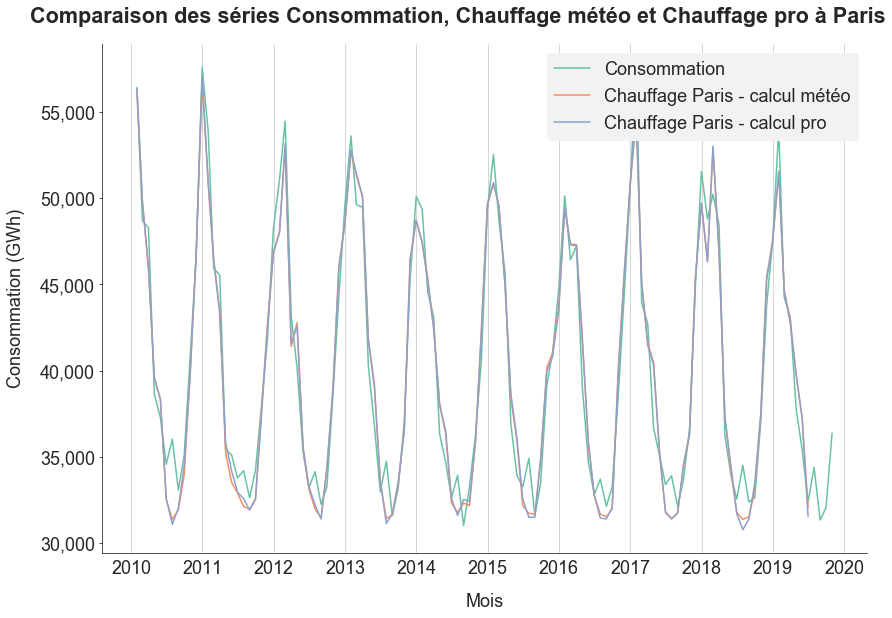

In [27]:
graph02a = sfg.MyGraph("Comparaison des séries Consommation, Chauffage météo et Chauffage pro à Paris")
graph02a.add_plot(consommation.date, consommation.consommation, label="Consommation")
graph02a.add_plot(consommation.date, consommation.chauffage_meteo_paris, label="Chauffage Paris - calcul météo")
graph02a.add_plot(consommation.date, consommation.chauffage_pro_paris, label="Chauffage Paris - calcul pro", with_grid='x', legend=True)
graph02a.set_axe('y', label="Consommation (GWh)", tick_dash=True, tick_labels_format=':,.0f')
graph02a.set_axe('x', label="Mois")
fig, ax = graph02a.fig, graph02a.ax
plt.show()

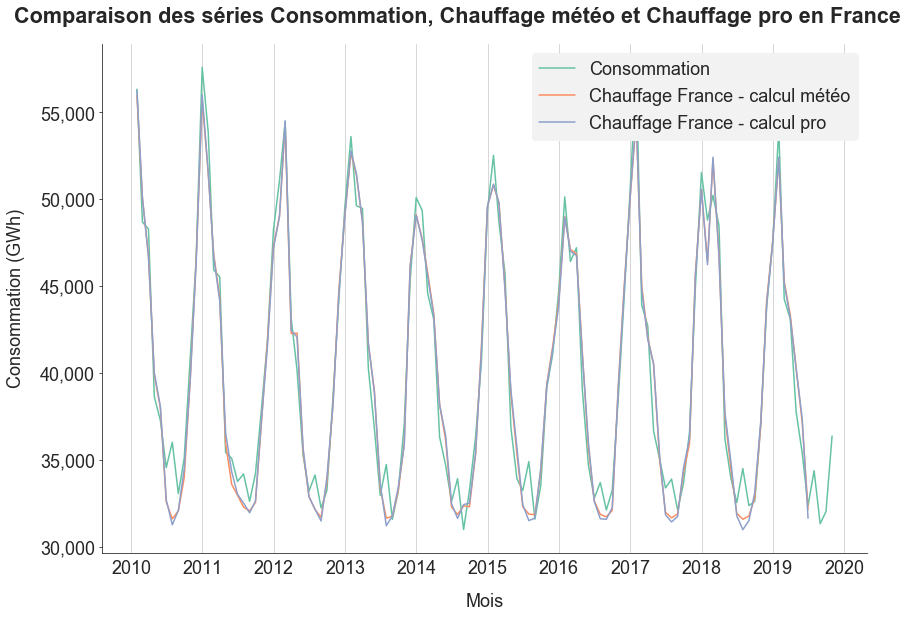

In [28]:
graph02b = sfg.MyGraph("Comparaison des séries Consommation, Chauffage météo et Chauffage pro en France")
graph02b.add_plot(consommation.date, consommation.consommation, label="Consommation")
graph02b.add_plot(consommation.date, consommation.chauffage_meteo_france, label="Chauffage France - calcul météo")
graph02b.add_plot(consommation.date, consommation.chauffage_pro_france, label="Chauffage France - calcul pro", with_grid='x', legend=True)
graph02b.set_axe('y', label="Consommation (GWh)", tick_dash=True, tick_labels_format=':,.0f')
graph02b.set_axe('x', label="Mois")
fig, ax = graph02b.fig, graph02b.ax
plt.show()

<a id='0_4'></a>

### 0.4. Date de fin des données

Les données dju ne se terminent pas à la même date.

In [29]:
consommation.drop(columns=["dju_meteo_paris","dju_pro_paris","dju_meteo_france","dju_pro_france"], inplace=True)
consommation.tail()

,date,consommation,chauffage_meteo_paris,chauffage_pro_paris,chauffage_meteo_france,chauffage_pro_france
113,2019-06-30,32376,32069.692461,31549.893599,32168.813549,31655.418997
114,2019-07-31,34390,NaN,NaN,NaN,NaN
115,2019-08-31,31337,NaN,NaN,NaN,NaN
116,2019-09-30,32047,NaN,NaN,NaN,NaN
117,2019-10-31,36384,NaN,NaN,NaN,NaN


Les données sur la consommation s'arrêtent au 31 octobre 2019.  
Les données dju s'arrêtent au 30 juin 2019.

Nous avons 3 possibilités pour notre projet :  
- conserver les seules données en années pleines jusqu'à fin 2018, et supprimer les données de 2019 ;  
- uniformaliser la date de fin des données au 30 juin 2019 (dernières données disponibles pour nos 2 séries) ;  
- garder toutes les données : les données dju vont servir à désaisonnaliser les données de consommation. Comme la saisonnalité sera estimée avec une régression linéaire, les données de saisonnalité sont les mêmes pour tous les ans, et donc peuvent facilement être utilisées pour la fin de la série temporelle.  
  
J'utiliserai la première option pour mon projet, afin d'avoir des années complètes.

In [30]:
# première option
consommation_1 = consommation[consommation.date.dt.year <= 2018].copy()
consommation_1.to_csv("donnees_projet09_2018.csv")

In [31]:
# deuxième option
consommation_2 = consommation[consommation.date <= '2019-06-30'].copy()
consommation_2.to_csv("donnees_projet09_20190630.csv")

In [32]:
# troisième option
consommation.to_csv("donnees_projet09_all.csv")

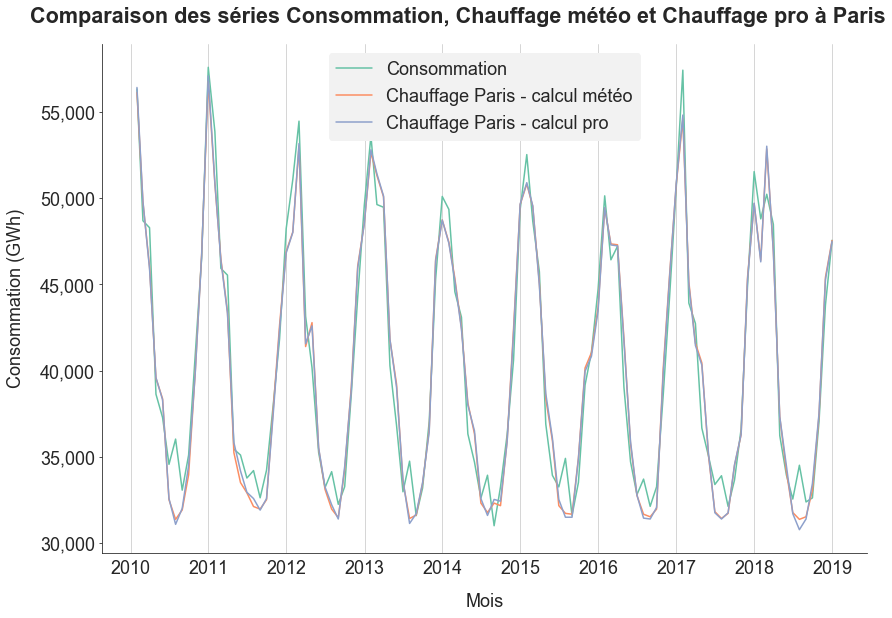

In [37]:
graph03 = sfg.MyGraph("Comparaison des séries Consommation, Chauffage météo et Chauffage pro à Paris")
graph03.add_plot(consommation_1.date, consommation_1.consommation, label="Consommation")
graph03.add_plot(consommation_1.date, consommation_1.chauffage_meteo_paris, label="Chauffage Paris - calcul météo")
graph03.add_plot(consommation_1.date, consommation_1.chauffage_pro_paris, label="Chauffage Paris - calcul pro", with_grid='x', legend=True)
graph03.set_axe('y', label="Consommation (GWh)", tick_dash=True, tick_labels_format=':,.0f')
graph03.set_axe('x', label="Mois")
fig, ax = graph03.fig, graph03.ax
plt.savefig("M0_g3_ts_uniformisées.png")
plt.show()